In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL
import warnings
warnings.filterwarnings('ignore')

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [28]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224  # 224:소수가 많아서! # 256

In [16]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "./SkinCancer/"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [29]:
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [18]:
import os
os.getcwd()

'/Users/goeun/Documents/YearDream/python/08_CV(이정훈 강사님)/0712_ImagePreprocessing'

# Generator의 두가지 argument

<b>Shuffle = FALSE<br>
class_mode = 'categorical' or binary</b>

In [30]:
# 중요한 argument: shuffle
# 중요한 argument: class_mode

TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')  

Found 60 images belonging to 2 classes.


### Training : Shuffle은 무조건 True <br>
### Test : Shuffle은 무조건 False

## 데이터 labels & filenames

In [20]:
TEST_GENERATOR.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [21]:
TEST_GENERATOR.filenames

['akiec/ISIC_0024329.jpg',
 'akiec/ISIC_0024707.jpg',
 'akiec/ISIC_0024710.jpg',
 'akiec/ISIC_0025247.jpg',
 'akiec/ISIC_0025368.jpg',
 'akiec/ISIC_0025605.jpg',
 'akiec/ISIC_0026626.jpg',
 'akiec/ISIC_0026645.jpg',
 'akiec/ISIC_0026872.jpg',
 'akiec/ISIC_0026981.jpg',
 'akiec/ISIC_0026992.jpg',
 'akiec/ISIC_0027047.jpg',
 'akiec/ISIC_0027178.jpg',
 'akiec/ISIC_0027184.jpg',
 'akiec/ISIC_0027231.jpg',
 'akiec/ISIC_0027294.jpg',
 'akiec/ISIC_0028335.jpg',
 'akiec/ISIC_0028370.jpg',
 'akiec/ISIC_0028659.jpg',
 'akiec/ISIC_0028872.jpg',
 'akiec/ISIC_0029043.jpg',
 'akiec/ISIC_0029067.jpg',
 'akiec/ISIC_0029133.jpg',
 'akiec/ISIC_0029279.jpg',
 'akiec/ISIC_0030280.jpg',
 'akiec/ISIC_0030341.jpg',
 'akiec/ISIC_0030344.jpg',
 'akiec/ISIC_0030491.jpg',
 'akiec/ISIC_0030549.jpg',
 'akiec/ISIC_0030602.jpg',
 'melanoma/ISIC_0024481.jpg',
 'melanoma/ISIC_0024729.jpg',
 'melanoma/ISIC_0024792.jpg',
 'melanoma/ISIC_0024987.jpg',
 'melanoma/ISIC_0025265.jpg',
 'melanoma/ISIC_0025394.jpg',
 'melanoma

In [31]:
item = TEST_GENERATOR.__getitem__(0)

print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[0]: (32, 224, 224, 3)
item[1]: (32, 2)
batch_index: 0


In [32]:
item = TEST_GENERATOR.next()
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[0]: (32, 224, 224, 3)
item[1]: (32, 2)
batch_index: 1


In [33]:
# batch index 위치표시 
print('batch_index:', TEST_GENERATOR.batch_index)
item = TEST_GENERATOR.next() # batch_size = 32 인데 데이터가 총 60개여서 나머지 28개만 가져옴, batch index = 0, -> 처음으로 돌아감 (32개: 1, 32개중 28개:0, 다 돌아서 0임)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

batch_index: 1
item[0]: (28, 224, 224, 3)
item[1]: (28, 2)
batch_index: 0


In [ ]:
# print('batch_index:', TEST_GENERATOR.batch_index())
# X, Y = TEST_GENERATOR.next()
# print('item[0]:', X.shape)
# print('item[1]:', Y.shape)

<b> 실제로 model.fit 안에 들어갈 때, GENERATOR 객체의 next 함수를 이용하여 데이터를 호출하고, loss를 계산한다. </b>

In [34]:
# 중요한 argument: shuffle
# 중요한 argument: class_mode

TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

Found 60 images belonging to 2 classes.


In [35]:
item = TEST_GENERATOR.next()
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[0]: (32, 224, 224, 3)
item[1]: (32,)
batch_index: 1


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [36]:
item[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

# Generator의 두가지 argument

<b>Shuffle = TRUE<br>
class_mode = 'binary'</b>

In [39]:
# 중요한 argument: shuffle
# 중요한 argument: class_mode
# test : shuffle X
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = True,
    class_mode='binary')

Found 60 images belonging to 2 classes.


In [40]:
TEST_GENERATOR.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [41]:
TEST_GENERATOR.filenames

['akiec/ISIC_0024329.jpg',
 'akiec/ISIC_0024707.jpg',
 'akiec/ISIC_0024710.jpg',
 'akiec/ISIC_0025247.jpg',
 'akiec/ISIC_0025368.jpg',
 'akiec/ISIC_0025605.jpg',
 'akiec/ISIC_0026626.jpg',
 'akiec/ISIC_0026645.jpg',
 'akiec/ISIC_0026872.jpg',
 'akiec/ISIC_0026981.jpg',
 'akiec/ISIC_0026992.jpg',
 'akiec/ISIC_0027047.jpg',
 'akiec/ISIC_0027178.jpg',
 'akiec/ISIC_0027184.jpg',
 'akiec/ISIC_0027231.jpg',
 'akiec/ISIC_0027294.jpg',
 'akiec/ISIC_0028335.jpg',
 'akiec/ISIC_0028370.jpg',
 'akiec/ISIC_0028659.jpg',
 'akiec/ISIC_0028872.jpg',
 'akiec/ISIC_0029043.jpg',
 'akiec/ISIC_0029067.jpg',
 'akiec/ISIC_0029133.jpg',
 'akiec/ISIC_0029279.jpg',
 'akiec/ISIC_0030280.jpg',
 'akiec/ISIC_0030341.jpg',
 'akiec/ISIC_0030344.jpg',
 'akiec/ISIC_0030491.jpg',
 'akiec/ISIC_0030549.jpg',
 'akiec/ISIC_0030602.jpg',
 'melanoma/ISIC_0024481.jpg',
 'melanoma/ISIC_0024729.jpg',
 'melanoma/ISIC_0024792.jpg',
 'melanoma/ISIC_0024987.jpg',
 'melanoma/ISIC_0025265.jpg',
 'melanoma/ISIC_0025394.jpg',
 'melanoma

In [42]:
item = TEST_GENERATOR.__getitem__(0)

print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[0]: (32, 224, 224, 3)
item[1]: (32,)
batch_index: 0


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [46]:
item = TEST_GENERATOR.next()

print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[1]

item[0]: (28, 224, 224, 3)
item[1]: (28,)
batch_index: 0


array([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.], dtype=float32)

# Shuffle 되어있음!

In [43]:
item[1]

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

# 가장 큰 problem: Dimension conversion

In [47]:
# 중요한 argument: shuffle
# 중요한 argument: class_mode

TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')

Found 60 images belonging to 2 classes.


In [48]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TEST_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TEST_GENERATOR.batch_index)

item[0]: (32, 224, 224, 3)
item[1]: (32, 2)
batch_index: 0


In [49]:
item[0][0]

array([[[0.654902  , 0.54509807, 0.49803925],
        [0.654902  , 0.54509807, 0.5019608 ],
        [0.6509804 , 0.5411765 , 0.49411768],
        ...,
        [0.73333335, 0.5882353 , 0.5568628 ],
        [0.7372549 , 0.5921569 , 0.56078434],
        [0.7607844 , 0.61960787, 0.57254905]],

       [[0.65882355, 0.54901963, 0.5019608 ],
        [0.6666667 , 0.54901963, 0.5058824 ],
        [0.65882355, 0.5568628 , 0.5058824 ],
        ...,
        [0.72156864, 0.5882353 , 0.54901963],
        [0.7372549 , 0.5921569 , 0.5568628 ],
        [0.7372549 , 0.6039216 , 0.5647059 ]],

       [[0.6509804 , 0.5411765 , 0.49411768],
        [0.65882355, 0.54901963, 0.5058824 ],
        [0.6509804 , 0.5411765 , 0.49411768],
        ...,
        [0.72156864, 0.58431375, 0.56078434],
        [0.73333335, 0.5882353 , 0.5647059 ],
        [0.73333335, 0.6       , 0.56078434]],

       ...,

       [[0.58431375, 0.47450984, 0.3921569 ],
        [0.5882353 , 0.48627454, 0.41960788],
        [0.6       , 0

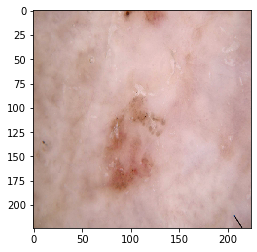

In [50]:
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [51]:
TEST_GENERATOR.filenames[0]

'akiec/ISIC_0024329.jpg'

In [54]:
Image = tf.keras.utils.load_img(
    test_directory + TEST_GENERATOR.filenames[0],
    grayscale=False,
    color_mode='rgb',
    target_size=None,
    interpolation='nearest',
    # keep_aspect_ratio=True
)

In [55]:
type(Image)

PIL.JpegImagePlugin.JpegImageFile

In [56]:
image_array = tf.keras.preprocessing.image.img_to_array(Image)

In [57]:
type(image_array)

numpy.ndarray

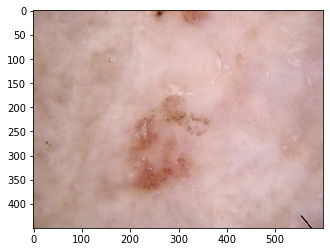

In [58]:
# RGB / Red image
plt.imshow(image_array / 255, interpolation='nearest', cmap='gray')
plt.show()

# 찌그러짐!! 
-> 마진을 없애더라도 'nearest'사용!